# 2D Batch Generator

In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
from tqdm import tqdm

Using TensorFlow backend.


In [237]:
keras.__version__

'2.2.0'

In [238]:
import tensorflow

In [239]:
tensorflow.__version__

'1.8.0'

## Metadata vs Lane
    * Metadata is the full dataset annotations
    * Lane is referres to the 'clean' version
    
    Note: The filenames column have the whole path to the image :)
    
    The data is sampled at 20Hz


In [2]:
# Open all 
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

#lane2 = pd.read_csv('Dataset/2016-01-30--13-46-00/Metadata/lane_df.csv',index_col=0)

#lane3 = pd.read_csv('Dataset/2016-01-31--19-19-25/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane8 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane9 = pd.read_csv('Dataset/2016-04-21--14-48-08/Metadata/metadata.csv',index_col=0)

#lane10 = pd.read_csv('Dataset/2016-05-12--22-20-00/Metadata/metadata.csv',index_col=0)

#lane11 = pd.read_csv('Dataset/2016-06-02--21-39-29/Metadata/metadata.csv',index_col=0)

#test = pd.read_csv('Dataset/2016-06-08--11-46-01/Metadata/metadata.csv',index_col=0)



In [3]:
X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 2.5 Hz
X = X[::4]
Y = Y[::4]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))

Shape X (46527,)
Shape Y (46527,)


## Opening images using the lane reference

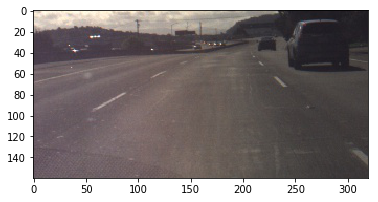

In [4]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filename = lane1['filenames'].iloc[0]
img = np.array(image.load_img(filename))
plt.imshow(img)

## Compute Optical Flow

In [5]:
# Compute previous frame
filename = lane1['filenames'].iloc[0]
frame1 = np.array(cv2.imread(filename))
prev = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

# Get present frame
filename = lane1['filenames'].iloc[2]
frame2 = np.array(cv2.imread(filename))
next_ = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

flow = cv2.calcOpticalFlowFarneback(prev, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

hsv[...,0] = ang*180/np.pi/2

hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    

In [6]:
def get_optical_flow(frame1, frame2):
    '''Frame1: previous frame
       Frame2: last frame
       Returns: Polar optical flow in RBG'''
    
    prev = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Get present frame
    next_ = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    hsv[...,0] = ang*180/np.pi/2

    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

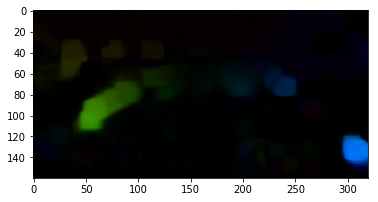

In [7]:
frame1 = np.array(cv2.imread(lane1['filenames'].iloc[0]))
frame2 = np.array(cv2.imread(lane1['filenames'].iloc[1]))
# frame1 previous image
# frame2 current image
plt.imshow(get_optical_flow(frame1, frame2))

## Stack current images + several optical flows
Create average of 4 previous optical flows

In [8]:

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[3])) # previous
frame2 = np.array(cv2.imread(lane1['filenames'].iloc[4])) # present

flow1 = get_optical_flow(frame1, frame2) # 4-3

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[2])) # previous

flow2 = get_optical_flow(frame1, frame2) # 4-2

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[1])) # previous

flow3 = get_optical_flow(frame1, frame2) # 4-1

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[0])) # previous

flow4 = get_optical_flow(frame1, frame2) # 4-0


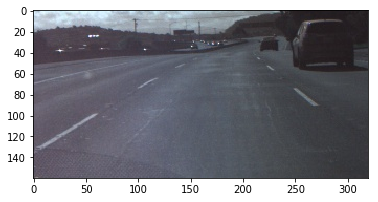

In [9]:
plt.imshow(frame2)

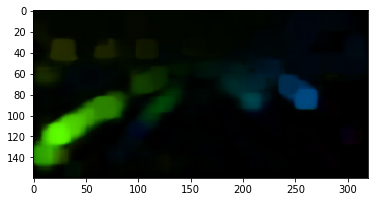

In [10]:
plt.imshow(flow1)

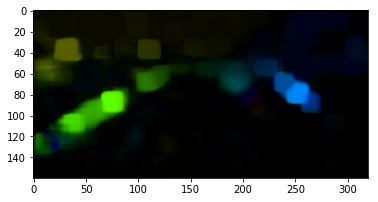

In [11]:
plt.imshow(flow2)

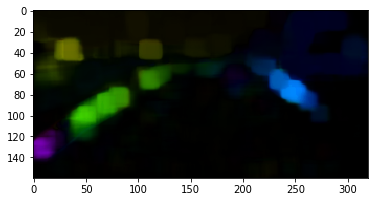

In [12]:
plt.imshow(flow3)

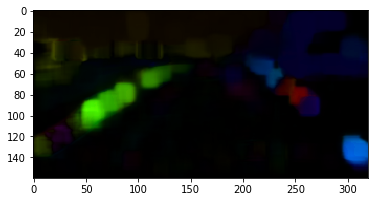

In [13]:
plt.imshow(flow4)

### Conclusion: 
First make a model only taking the last frame. After try to improve that. Apparently t - 4 gives a cool lane description :)
t - 4 = 1.6 secs in the past.

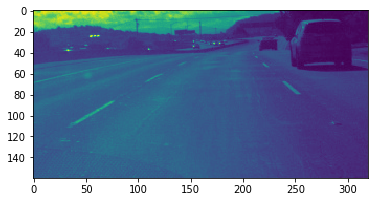

In [14]:
plt.imshow(next_)

## Batch Generator that computes optical flow 

In [15]:
from keras.utils import Sequence
import math
class Batch_generator(Sequence):
    '''Generates batches of images and labels on the fly from disc. 
    Uses process_line() function to perform image reading transformation.
    x_set: Numpy array with filenames (strings)
    y_set: Numpy array with binary gender labels (0,1)
    batch_size: Number of samples per batch
    '''
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

        return np.array([process_line(file_name)
                   for file_name in batch_x]), batch_y.astype('float32')
    
def process_line(filename):
    '''Process one line of the batch directory.------------------------
     Read a list of two filenames: previous - current.
     Returns the optical flow !!
    '''
    frame1 = np.array(cv2.imread(filename[0])) # previous
    frame2 = np.array(cv2.imread(filename[1])) # present
    flow = get_optical_flow(frame1, frame2) 
    
    return [frame1], [flow]     

## Generate image index by pairs :)

In [16]:
def get_index(X, Y, offset=4):
    new_X = []
    new_Y = []
    for i in range(int(X.shape[0]-offset)):
        pair_X = [X[i], X[i + offset]]
        new_X.append(pair_X)
        new_Y.append(Y[i + offset])
        
    return np.array(new_X), np.array(new_Y)

In [17]:
new_X, new_Y = get_index(X, Y, offset=4)

## Conv2D Models - Rambo

In [21]:
from keras.layers import *
from keras.models import Model

In [22]:
def spatial_model(input_shape=(160,320,3), dropout=0.1):
    """
    Classic NVIDIA model.
    """
    inputs = Input(input_shape)
    
    x = Lambda(lambda x: x/127.5-1.0, input_shape=input_shape)(inputs)
    
    x = Conv2D(24, (5, 5), activation='elu', strides=(2, 2), 
               input_shape=input_shape)(x)
    
    x = Conv2D(36, (5, 5), activation='elu', strides=(2, 2))(x)

    x = Conv2D(48, (5, 5), activation='elu', strides=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='elu')(x)

    x = Conv2D(64, (3, 3), activation='elu')(x)
    
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    
    model = Model(inputs, x) # Take only the flatten

    return model


def temporal_model(input_shape=(160,320,3)):

    inputs = Input(input_shape)

    x = Lambda(lambda x: x/127.5-1.0, input_shape=input_shape)(inputs)

    x = Conv2D(16, (8, 8), strides=4, padding="same")(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv2D(32, (5, 5), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv2D(64, (5, 5), strides=2, padding="same")(x)
    
    x = Flatten()(x)
    
    model = Model(inputs, x) # Take only the flatten

    return model

In [23]:
# Create both models
model1 = spatial_model()
model2 = temporal_model()


In [24]:
#mergedOut = Add()([model1.output,model2.output])   #SUM
mergedOut = Concatenate()([model1.output,model2.output]) #CONCAT

In [25]:
# Complete the fully connected output
#mergedOut = Flatten()(mergedOut)    

mergedOut = Dense(512, activation='elu')(mergedOut)
mergedOut = Dropout(.1)(mergedOut)

mergedOut = Dense(128, activation='elu')(mergedOut)

mergedOut = Dense(64, activation='elu')(mergedOut)

mergedOut = Dense(10, activation='elu')(mergedOut)
mergedOut = Dropout(.1)(mergedOut)

# output layer
mergedOut = Dense(1, activation='linear')(mergedOut)

In [26]:
# Get the final models
newModel = Model([model1.input,model2.input], mergedOut)

newModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 160, 320, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 160, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (

In [54]:
import keras as K
from keras.optimizers import Adam

def rmse(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 


adam = Adam(lr=1e-4)
newModel.compile(optimizer=adam, loss='mse')

## Target pre-processing
No es sencillo crear un batch generator para dos clases!! piensalo bien.

Por esta vez, cargamos todo en RAM- para eso tenemos 61Gb :)

In [ ]:
# Each model has as input one of the images in the pair
# Temporal model: current image
# Spatial model: optical flow 
# Both models have the same desired output :)

#newModel.fit([X_train_1, X_train_2], Y_train, ....)    

#train1 = []
#train2 = []
#for element in tqdm(new_X):
    # Get current frame and optical flow
#    current, flow = process_line(element)
#    train1.append(current)
#    train2.append(flow)

#train1 = np.array(train1)   
#train2 = np.array(train2)    

In [264]:
np.shape(train1)

(46523, 1, 160, 320, 3)

In [265]:
np.shape(train2)

(46523, 1, 160, 320, 3)

In [274]:
train1 = train1.reshape(-1,160,320,3)

In [275]:
train2 = train2.reshape(-1,160,320,3)

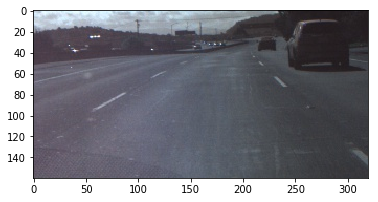

In [276]:
plt.imshow(train1[0])

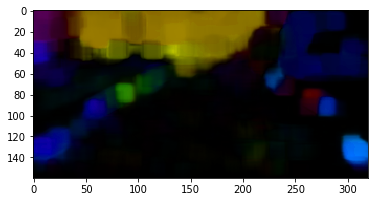

In [277]:
plt.imshow(train2[0])

## Normalize target new_Y

In [30]:
# Normalize target
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(new_Y.reshape(-1,1))

new_y = scaler.transform(new_Y.reshape(-1,1))

## Shuffle training examples 

In [34]:
# Suffle examples
import random
proportion = 1
# Generate a random selection of indexes
indexes = random.sample(range(0, new_X.shape[0]), int(new_X.shape[0]*proportion))

# Select desired examples
shuffle_X = new_X[indexes]
shuffle_Y = new_y[indexes].astype('float32') # Already normalized


  3%|▎         | 1182/46523 [00:40<25:34, 29.55it/s]

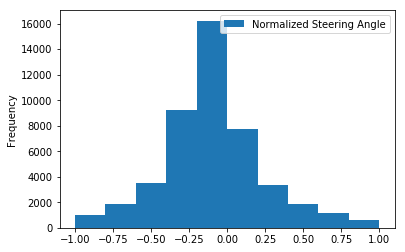

In [32]:
df_y = pd.DataFrame(shuffle_Y)
df_y.columns = ['Normalized Steering Angle']
df_y.plot.hist()

In [35]:
train1 = []
train2 = []
for element in tqdm(shuffle_X):
    # Get current frame and optical flow
    current, flow = process_line(element)
    train1.append(current)
    train2.append(flow)

train1 = np.array(train1)   
train2 = np.array(train2) 


  2%|▏         | 888/46523 [00:16<13:48, 55.07it/s]


  4%|▍         | 1764/46523 [00:32<13:34, 54.97it/s]


  6%|▌         | 2640/46523 [00:48<13:19, 54.88it/s]


  8%|▊         | 3516/46523 [01:04<13:04, 54.84it/s]


  9%|▉         | 4392/46523 [01:20<12:48, 54.81it/s]


 11%|█▏        | 5268/46523 [01:36<12:32, 54.81it/s]


 13%|█▎        | 6144/46523 [01:52<12:16, 54.81it/s]


 15%|█▌        | 7020/46523 [02:08<12:00, 54.81it/s]


 17%|█▋        | 7896/46523 [02:24<11:44, 54.81it/s]


 19%|█▉        | 8772/46523 [02:40<11:28, 54.81it/s]


 21%|██        | 9648/46523 [02:56<11:12, 54.79it/s]


 23%|██▎       | 10512/46523 [03:11<10:57, 54.78it/s]


 24%|██▍       | 11370/46523 [03:27<10:41, 54.78it/s]


 26%|██▋       | 12228/46523 [03:43<10:26, 54.78it/s]


 28%|██▊       | 13086/46523 [03:58<10:10, 54.78it/s]


 30%|██▉       | 13944/46523 [04:14<09:54, 54.78it/s]


 32%|███▏      | 14802/46523 [04:30<09:39, 54.78it/s]


 34%|███▎      | 15660/46523 [04:45<09:23, 54.77it/s]


 36%|███▌      | 16518/46523 [05:01<09:07, 54.77it/s]


 37%|███▋      | 17376/46523 [05:17<08:52, 54.77it/s]


 39%|███▉      | 18234/46523 [05:32<08:36, 54.77it/s]


 41%|████      | 19092/46523 [05:48<08:20, 54.78it/s]


 43%|████▎     | 19950/46523 [06:04<08:05, 54.77it/s]


 45%|████▍     | 20808/46523 [06:19<07:49, 54.76it/s]


 47%|████▋     | 21666/46523 [06:35<07:33, 54.76it/s]


 48%|████▊     | 22524/46523 [06:51<07:18, 54.75it/s]


 50%|█████     | 23382/46523 [07:07<07:02, 54.75it/s]


 52%|█████▏    | 24240/46523 [07:22<06:46, 54.75it/s]


 54%|█████▍    | 25098/46523 [07:38<06:31, 54.75it/s]


 56%|█████▌    | 25956/46523 [07:54<06:15, 54.75it/s]


 58%|█████▊    | 26814/46523 [08:09<06:00, 54.74it/s]


 59%|█████▉    | 27672/46523 [08:25<05:44, 54.75it/s]


 61%|██████▏   | 28530/46523 [08:41<05:28, 54.75it/s]


 63%|██████▎   | 29388/46523 [08:56<05:12, 54.74it/s]


 65%|██████▌   | 30246/46523 [09:12<04:57, 54.73it/s]


 67%|██████▋   | 31104/46523 [09:28<04:41, 54.73it/s]


 69%|██████▊   | 31962/46523 [09:43<04:26, 54.73it/s]


 71%|███████   | 32820/46523 [09:59<04:10, 54.73it/s]


 72%|███████▏  | 33678/46523 [10:15<03:54, 54.73it/s]


 74%|███████▍  | 34536/46523 [10:30<03:38, 54.74it/s]


 76%|███████▌  | 35394/46523 [10:46<03:23, 54.74it/s]


 78%|███████▊  | 36252/46523 [11:02<03:07, 54.73it/s]


 80%|███████▉  | 37110/46523 [11:18<02:51, 54.73it/s]


 82%|████████▏ | 37968/46523 [11:33<02:36, 54.73it/s]


 83%|████████▎ | 38826/46523 [11:49<02:20, 54.73it/s]


 85%|████████▌ | 39683/46523 [12:05<02:04, 54.72it/s]


 87%|████████▋ | 40541/46523 [12:20<01:49, 54.72it/s]


 89%|████████▉ | 41399/46523 [12:36<01:33, 54.72it/s]


 91%|█████████ | 42257/46523 [12:52<01:17, 54.72it/s]


 93%|█████████▎| 43115/46523 [13:07<01:02, 54.73it/s]


 95%|█████████▍| 43973/46523 [13:23<00:46, 54.73it/s]


 96%|█████████▋| 44831/46523 [13:39<00:30, 54.73it/s]


 98%|█████████▊| 45689/46523 [13:54<00:15, 54.73it/s]


100%|██████████| 46523/46523 [14:10<00:00, 54.73it/s]


In [36]:
train1 = train1.reshape(-1,160,320,3)   
train2 = train2.reshape(-1,160,320,3)

In [57]:
train1.shape

(46523, 160, 320, 3)

In [59]:
train2.shape

(46523, 160, 320, 3)

In [60]:
train1[:36000].shape

(36000, 160, 320, 3)

## It would be nice to apply data augmentation!!

In [268]:
!pip install pydot

distributed 1.21.8 requires msgpack, which is not installed.


In [28]:
#from keras.utils import plot_model
#plot_model(newModel, to_file='two_streams.png', show_shapes=True)

In [37]:
from keras.callbacks import *

In [64]:

# Create batch generator for training and validation
#img_path = './CACD_NUMPY/'
#batch_size = 100

#train_X1 = train1[:36000]
#train_X2 = train2[:36000]
#train_Y = shuffle_Y[:36000]

#val_X1 = train1[36000:44000]
#val_X2 = train2[36000:44000]
#val_Y = shuffle_Y[36000:44000]

#test_X1 = train1[44000:]
#test_X2 = train2[44000:]
#test_Y = shuffle_Y[44000:]

# Initialize batch generators
#train_gen = Batch_generator(train_X, train_Y, batch_size)
#val_gen = Batch_generator(val_X, val_Y, batch_size)


#steps_per_epoch = int(train_X.shape[0] / batch_size)
#validation_steps = int(val_X.shape[0] / batch_size)

# Create model
#model = baseline()
#model = commaai_model()
# For a binary classification problem
#model.compile(optimizer='SGD',
#              loss='mse')


# Configure Keras Callbacks
model_name = 'two_streams2.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
newModel.fit([train1,train2], shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.2,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=100
            )    


#history = newModel.fit_generator(train_gen, steps_per_epoch=steps_per_epoch,
#                    epochs=100, verbose=1,
#                    callbacks=[early_stop, reduce_LR, snapshot], validation_data=val_gen,
#                    validation_steps= validation_steps, class_weight=None,
#                    max_queue_size=10, workers=8,
#                    use_multiprocessing=True, shuffle=True, initial_epoch=0)

newModel.save('last_stream.hdf5')
# Best result so far - Shuffle data !!!!! Epoch42
#750/750 [==============================] - 205s 274ms/step - loss: 0.0265 - val_loss: 0.0729


Train on 37218 samples, validate on 9305 samples
Epoch 1/100
37218/37218 [==============================] - 111s 3ms/step - loss: 0.0078 - val_loss: 0.0324

Epoch 00001: val_loss improved from inf to 0.03236, saving model to two_streams2.hdf5


RuntimeError: Problems closing file (file write failed: time = Thu Jul 19 15:44:32 2018
, filename = 'two_streams2.hdf5', file descriptor = 71, errno = 28, error message = 'No space left on device', buf = 0x5647a19ea870, total write size = 10192, bytes this sub-write = 10192, bytes actually written = 18446744073709551615, offset = 4096)

In [40]:
#newModel.save('last_stream.hdf5')


In [44]:
from keras.models import load_model
from keras.optimizers import Adam

In [45]:
net = load_model('two_streams.hdf5',custom_objects={'rmse': rmse})

AttributeError: 'function' object has no attribute 'sqrt'

In [47]:
from tqdm import tqdm
test = []
for i in tqdm(range(100)):
    test.append(newModel.predict(
                [np.expand_dims(train1[i], axis=0),
                 np.expand_dims(train2[i], axis=0)]
                ))
    


100%|██████████| 100/100 [00:00<00:00, 125.82it/s]

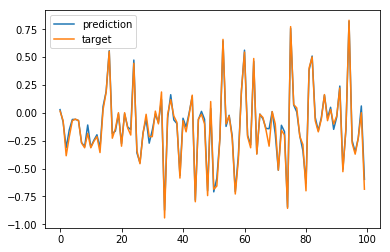

In [50]:
plt.plot(np.array(test).reshape(-1), label='prediction')
plt.plot(shuffle_Y[:100], label='target')
plt.legend()

In [52]:
import math
def error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1)) 
np.mean(error(shuffle_Y,test))

0.34702802

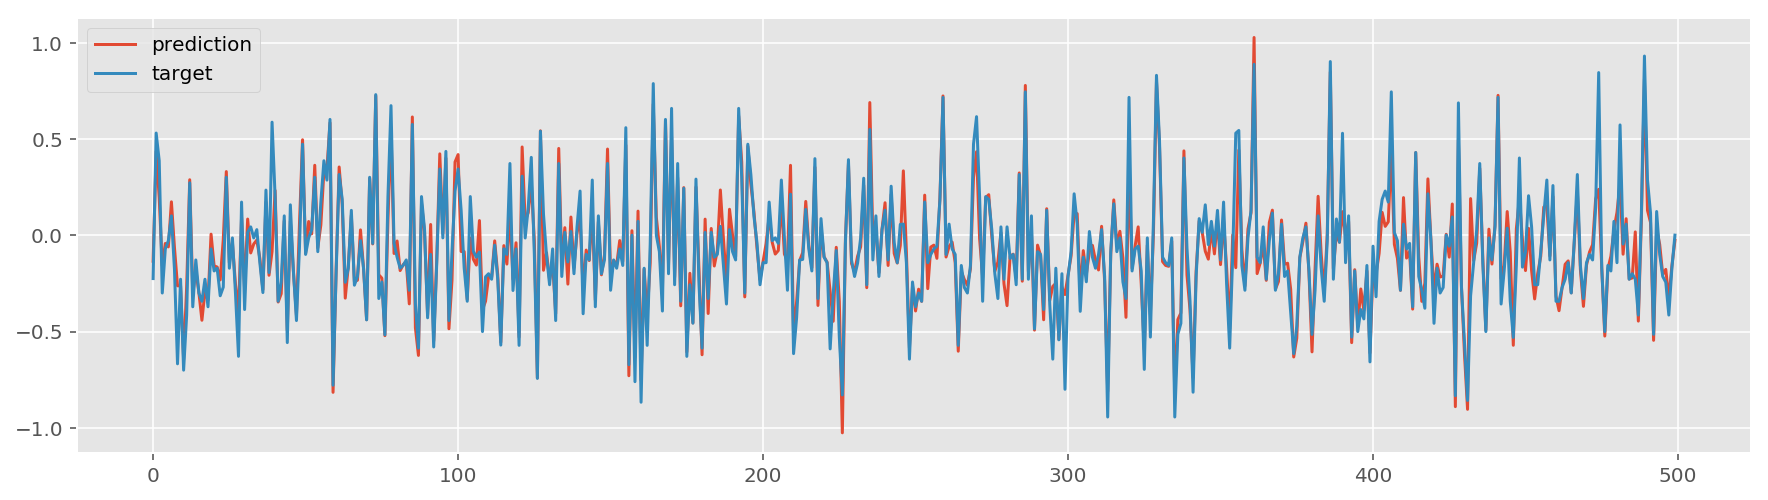

In [35]:
plt.plot(np.array(test).reshape(-1)[:500], label='prediction')
plt.plot(test_Y[:500], label='target')
plt.legend()

In [156]:
np.mean(error(test_Y,test))

0.2805248

5

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plt.style.use('ggplot')

def plot_train_loss(history):
  
  #plt.plot(history.history['acc'])
  #plt.plot(history.history['val_acc'])
  #plt.title('model accuracy')
  #plt.ylabel('accuracy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

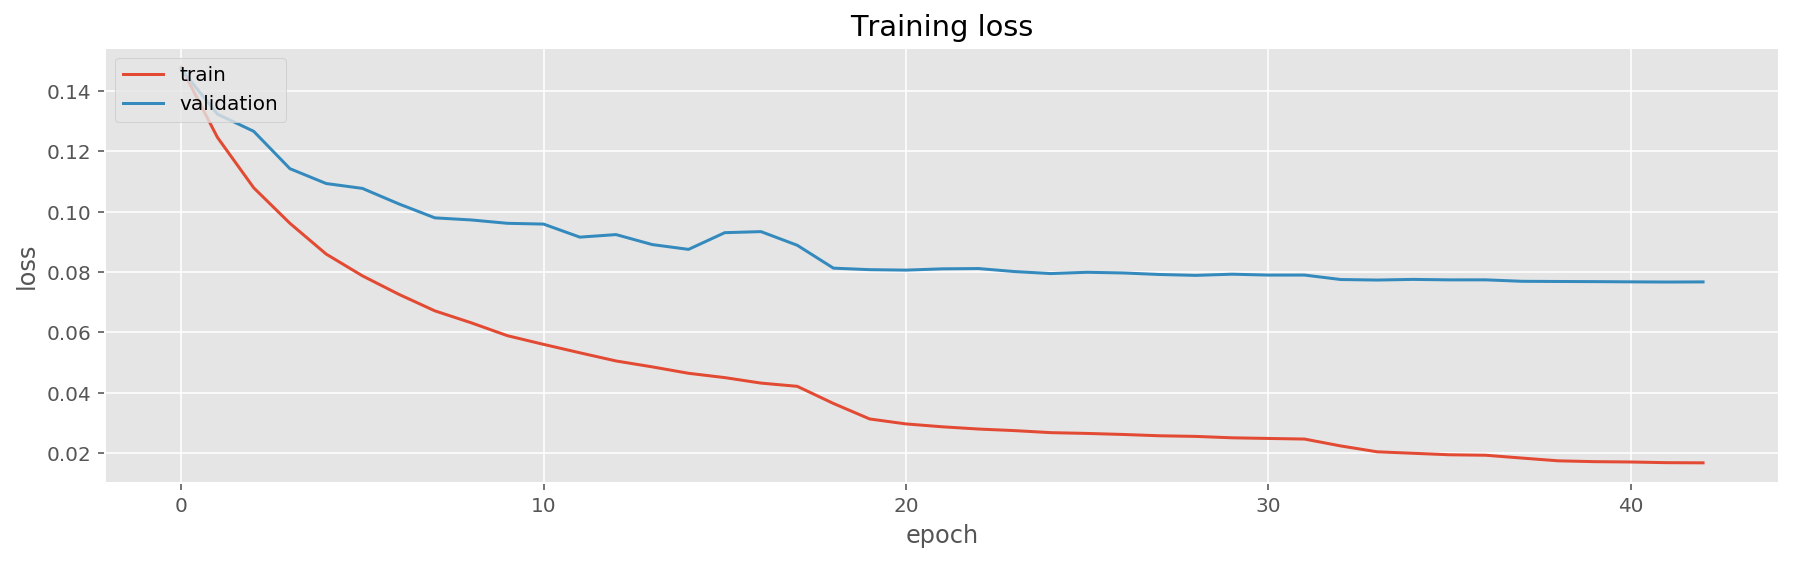

In [36]:
plot_train_loss(history)

In [28]:

def plot_train_loss(history):
  
  #plt.plot(history.history['acc'])
  #plt.plot(history.history['val_acc'])
  #plt.title('model accuracy')
  #plt.ylabel('accuracy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

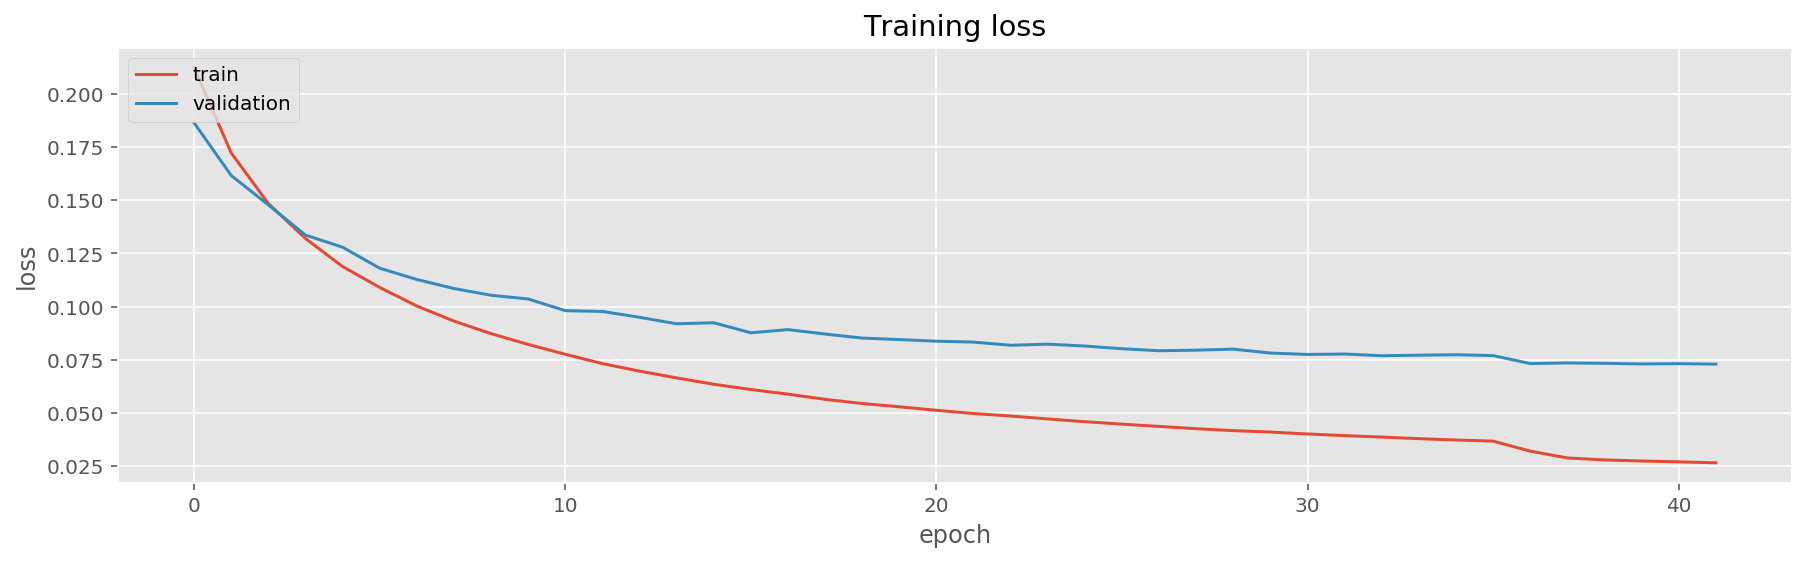

In [29]:
plot_train_loss(history)